# Exploratory Analysis

Minimum values:
 local_w          -488.902439
odometry_theta     -3.141588
dtype: float64
Maximum values:
 local_w           1498.414634
odometry_theta       3.141540
dtype: float64


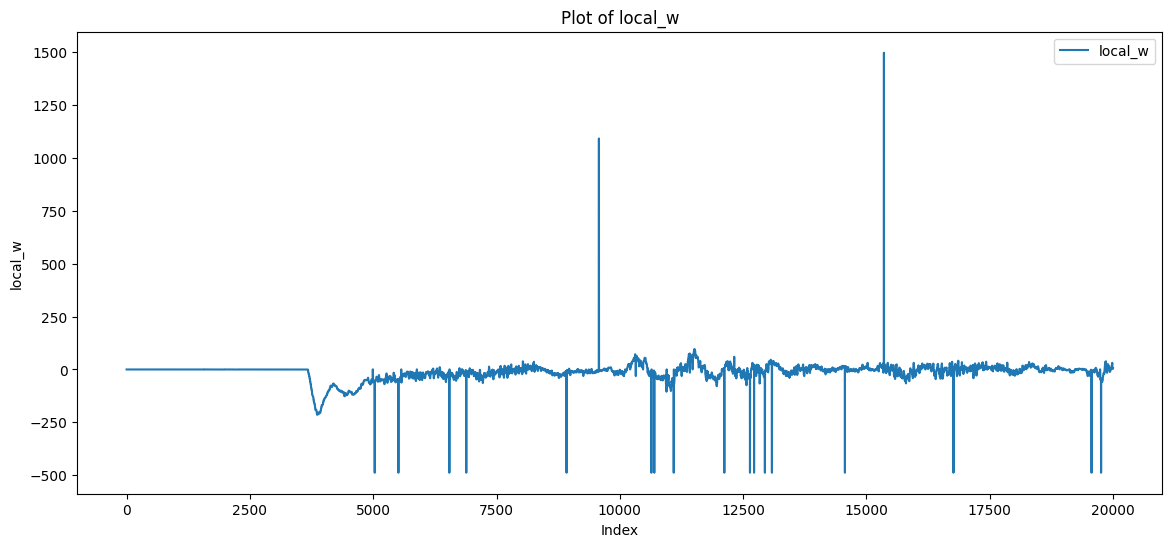

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
data = pd.read_csv('log.csv')

# Calculate min and max for each column
min_values = data.min()
max_values = data.max()

# Print min and max values
print("Minimum values:\n", min_values)
print("Maximum values:\n", max_values)

# Plot the data
plt.figure(figsize=(14, 6))

# Plot local_w
plt.plot(data['local_w'], label='local_w')
plt.xlabel('Index')
plt.ylabel('local_w')
plt.title('Plot of local_w')
plt.legend()
plt.show()

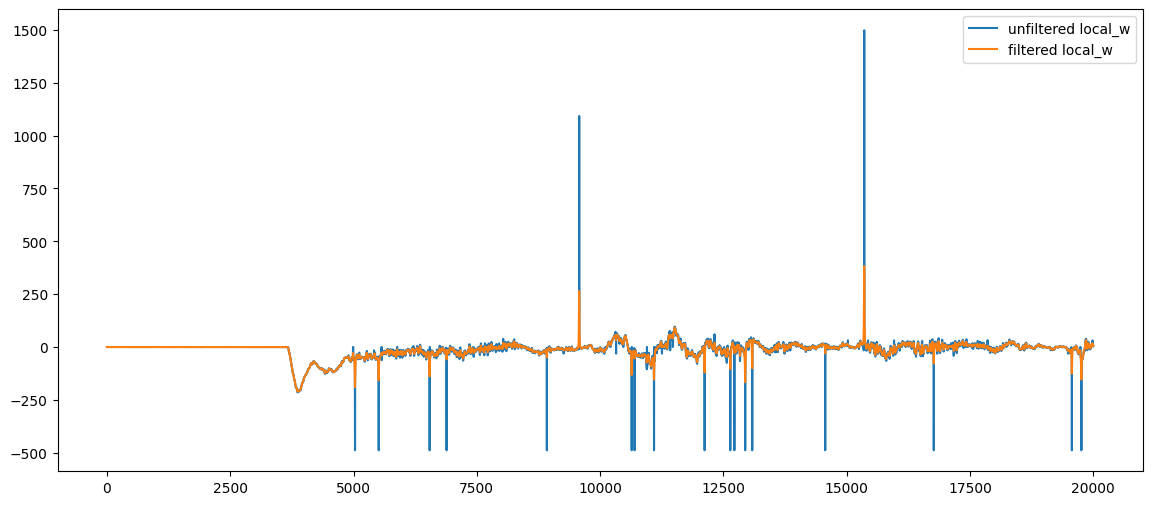

In [64]:
from scipy.signal import butter, filtfilt

#  Define the low pass filter
def low_pass_filter(data, cutoff_frequency, sampling_rate):
    nyquist_rate = 0.5 * sampling_rate
    normal_cutoff = cutoff_frequency / nyquist_rate
    b, a = butter(1, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# Apply the low pass filter to the data
sampling_rate = 1380  # Hz
cutoff_frequency = 42  # Hz

filtered_local_w = low_pass_filter(data['local_w'], cutoff_frequency, sampling_rate)
filtered_odometry_theta = low_pass_filter(data['odometry_theta'], cutoff_frequency, sampling_rate)

# Plot the data
plt.figure(figsize=(14, 6))

# Plot filtered local_w
plt.plot(data['local_w'], label='unfiltered local_w')
plt.plot(filtered_local_w, label='filtered local_w')
plt.legend()

plt.show()

# Processing Log Data

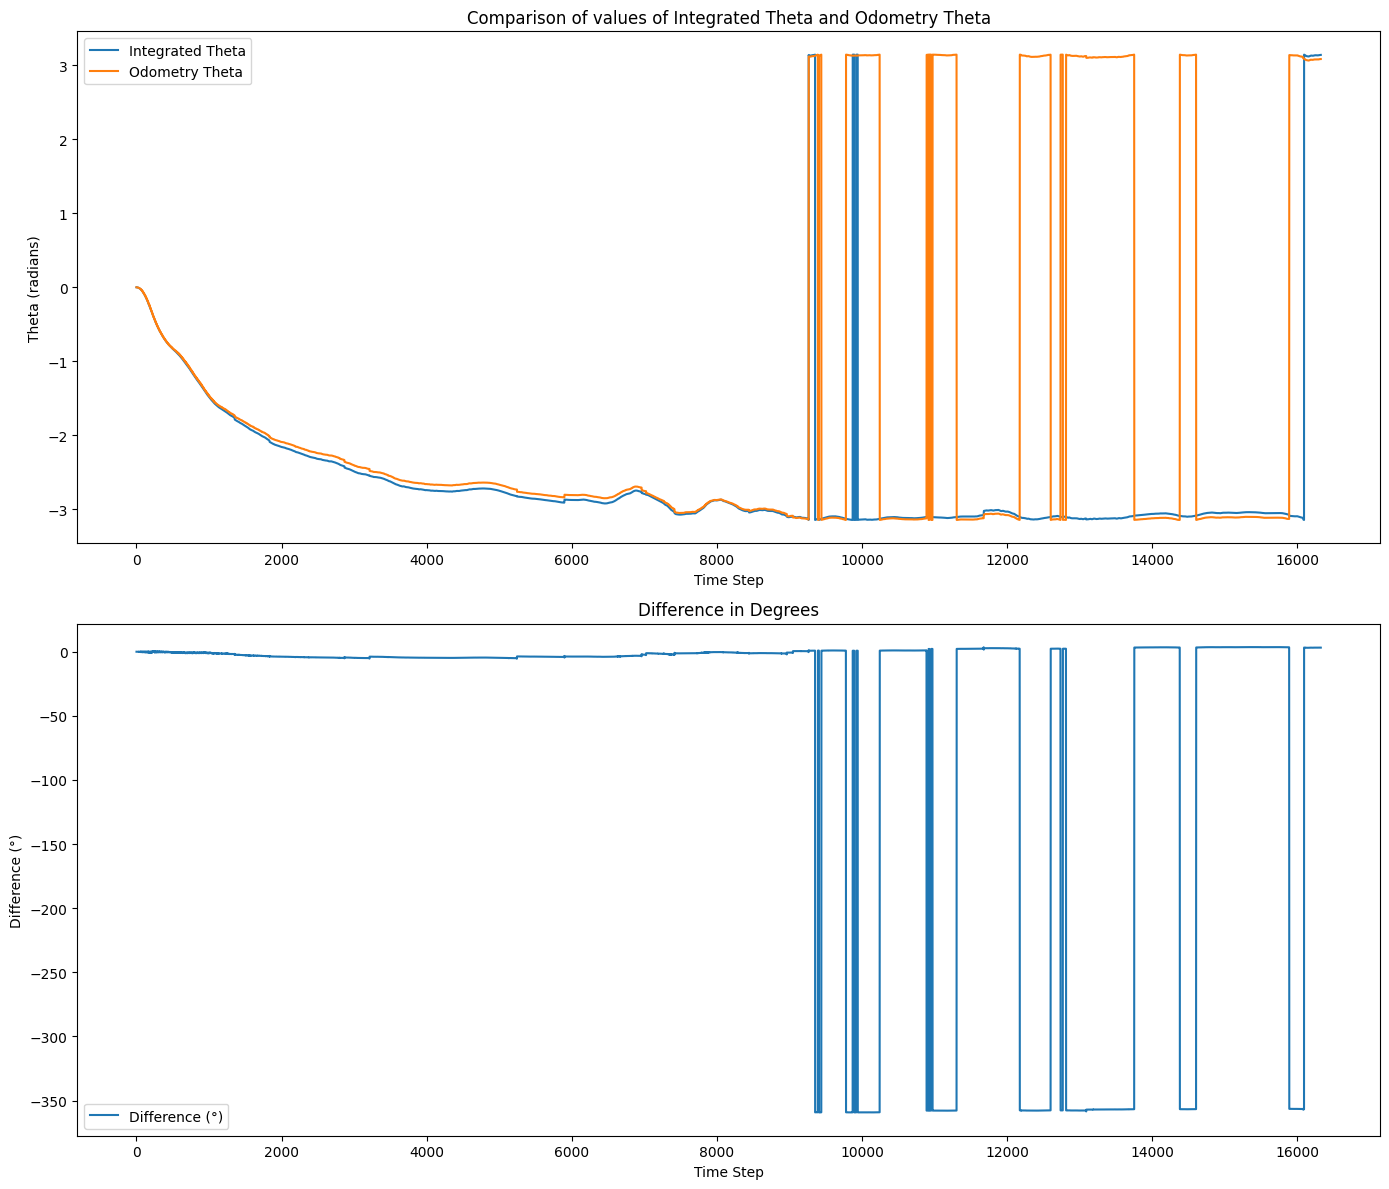

In [65]:
import math

def process_log_data(data, dt):
    integrated_theta_list = []
    odometry_theta_list = []
    difference_list = []

    integrated_theta_s = 0.0
    noise_values = []

    for i in range(3677):
        noise_values.append(data['local_w'][i])

    noise_offset = sum(noise_values) / len(noise_values)

    for i in range(3677, len(data)):
        local_w = data['local_w'][i] - noise_offset
        odometry_theta = data['odometry_theta'][i]
        local_w *= (math.pi / 180.0)  # Convert local_w from degrees/s to rad/s
        integrated_theta_s += local_w * dt
        integrated_theta_s = (integrated_theta_s + math.pi) % (2 * math.pi) - math.pi
        integrated_theta_list.append(integrated_theta_s)
        odometry_theta_list.append(odometry_theta)
        difference = (integrated_theta_s - odometry_theta) * (180.0 / math.pi)  # Convert to degrees
        difference_list.append(difference)

    return integrated_theta_list, odometry_theta_list, difference_list


integrated_theta_list, odometry_theta_list, difference_list = process_log_data(data, 1 / sampling_rate)

plt.figure(figsize=(14, 12))

plt.subplot(2, 1, 1)
plt.plot(integrated_theta_list, label='Integrated Theta')
plt.plot(odometry_theta_list, label='Odometry Theta')
plt.xlabel('Time Step')
plt.ylabel('Theta (radians)')
plt.legend()
plt.title('Comparison of values of Integrated Theta and Odometry Theta')

plt.subplot(2, 1, 2)
plt.plot(difference_list, label='Difference (°)')
plt.xlabel('Time Step')
plt.ylabel('Difference (°)')
plt.legend()
plt.title('Difference in Degrees')

plt.tight_layout()
plt.show()


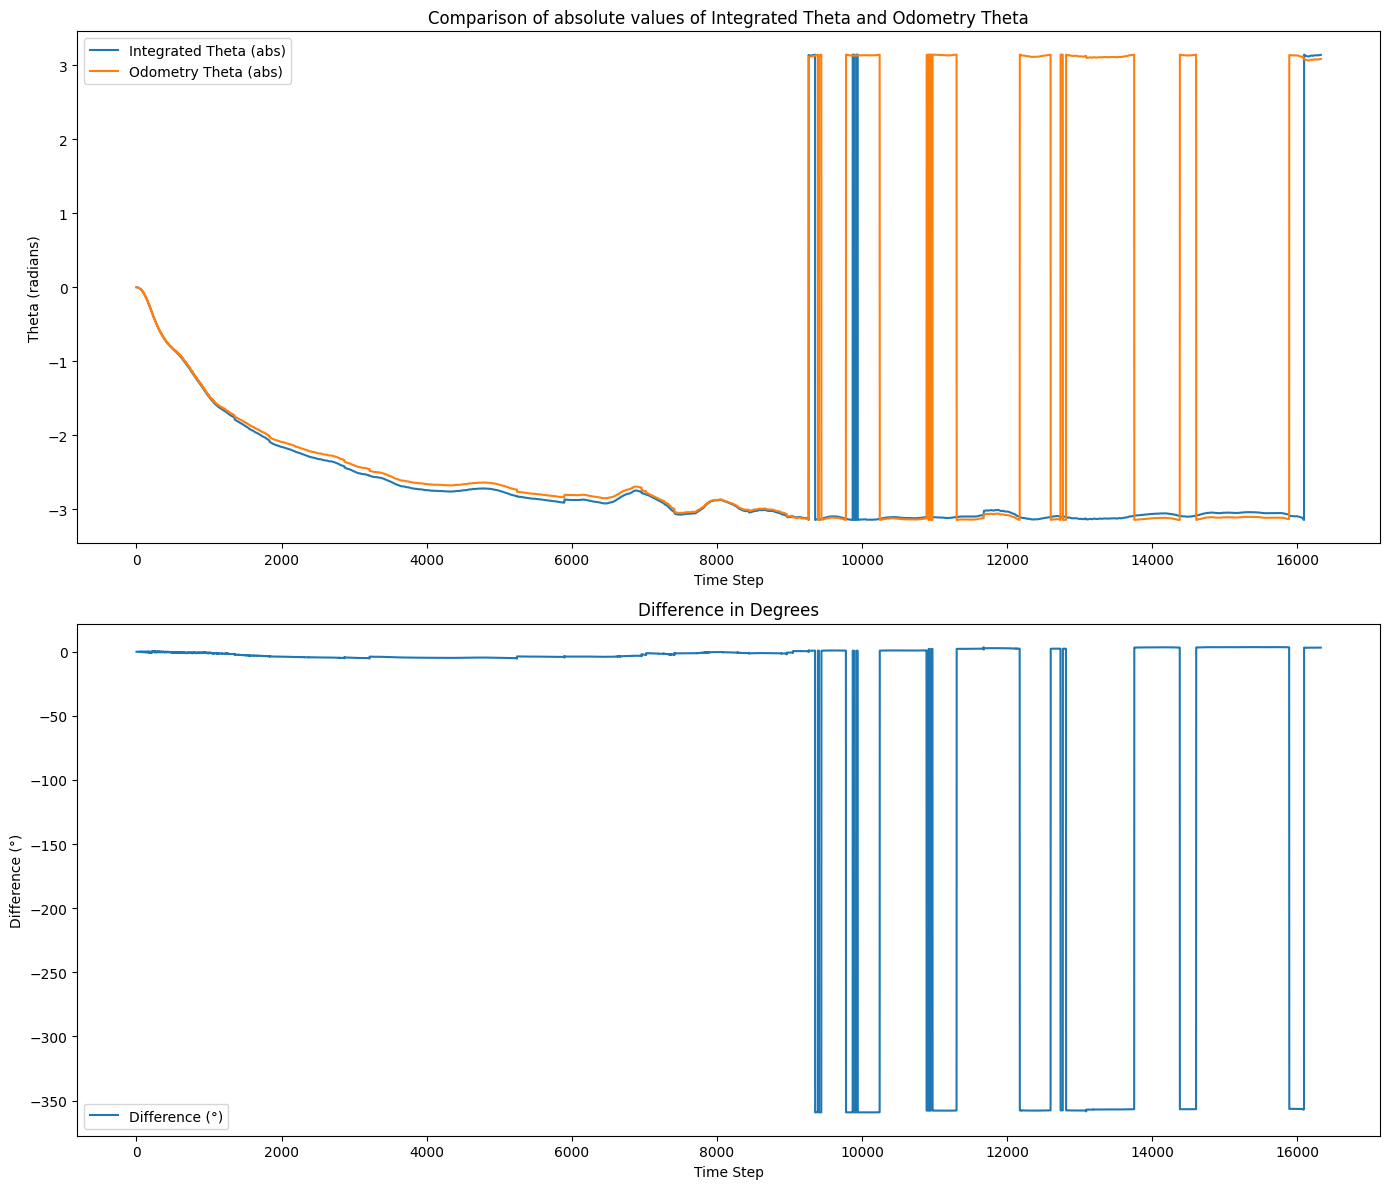

In [66]:
def process_log_data_abs(data, dt):
    integrated_theta_list = []
    odometry_theta_list = []
    difference_list = []

    integrated_theta_s = 0.0
    noise_values = []

    for i in range(3677):
        noise_values.append(data['local_w'][i])

    noise_offset = sum(noise_values) / len(noise_values)

    for i in range(3676, len(data)):
        local_w = data['local_w'][i] - noise_offset
        odometry_theta = abs(data['odometry_theta'][i])
        local_w *= (math.pi / 180.0)  # Convert local_w from degrees/s to rad/s
        integrated_theta_s += local_w * dt
        integrated_theta = abs(integrated_theta_s)
        integrated_theta_list.append(integrated_theta)
        odometry_theta_list.append(odometry_theta)
        difference = (integrated_theta - odometry_theta) * (180.0 / math.pi)  # Convert to degrees
        difference_list.append(difference)

    return integrated_theta_list, odometry_theta_list, difference_list

integrated_theta_list_abs, odometry_theta_list_abs, difference_list_abs = process_log_data_abs(data, 1 / sampling_rate)

plt.figure(figsize=(14, 12))

plt.subplot(2, 1, 1)
plt.plot(integrated_theta_list, label='Integrated Theta (abs)')
plt.plot(odometry_theta_list, label='Odometry Theta (abs)')
plt.xlabel('Time Step')
plt.ylabel('Theta (radians)')
plt.legend()
plt.title('Comparison of absolute values of Integrated Theta and Odometry Theta')

plt.subplot(2, 1, 2)
plt.plot(difference_list, label='Difference (°)')
plt.xlabel('Time Step')
plt.ylabel('Difference (°)')
plt.legend()
plt.title('Difference in Degrees')

plt.tight_layout()
plt.show()

The optimal dt is: 0.0007215994643345417, frequency: 1385.8103413674219


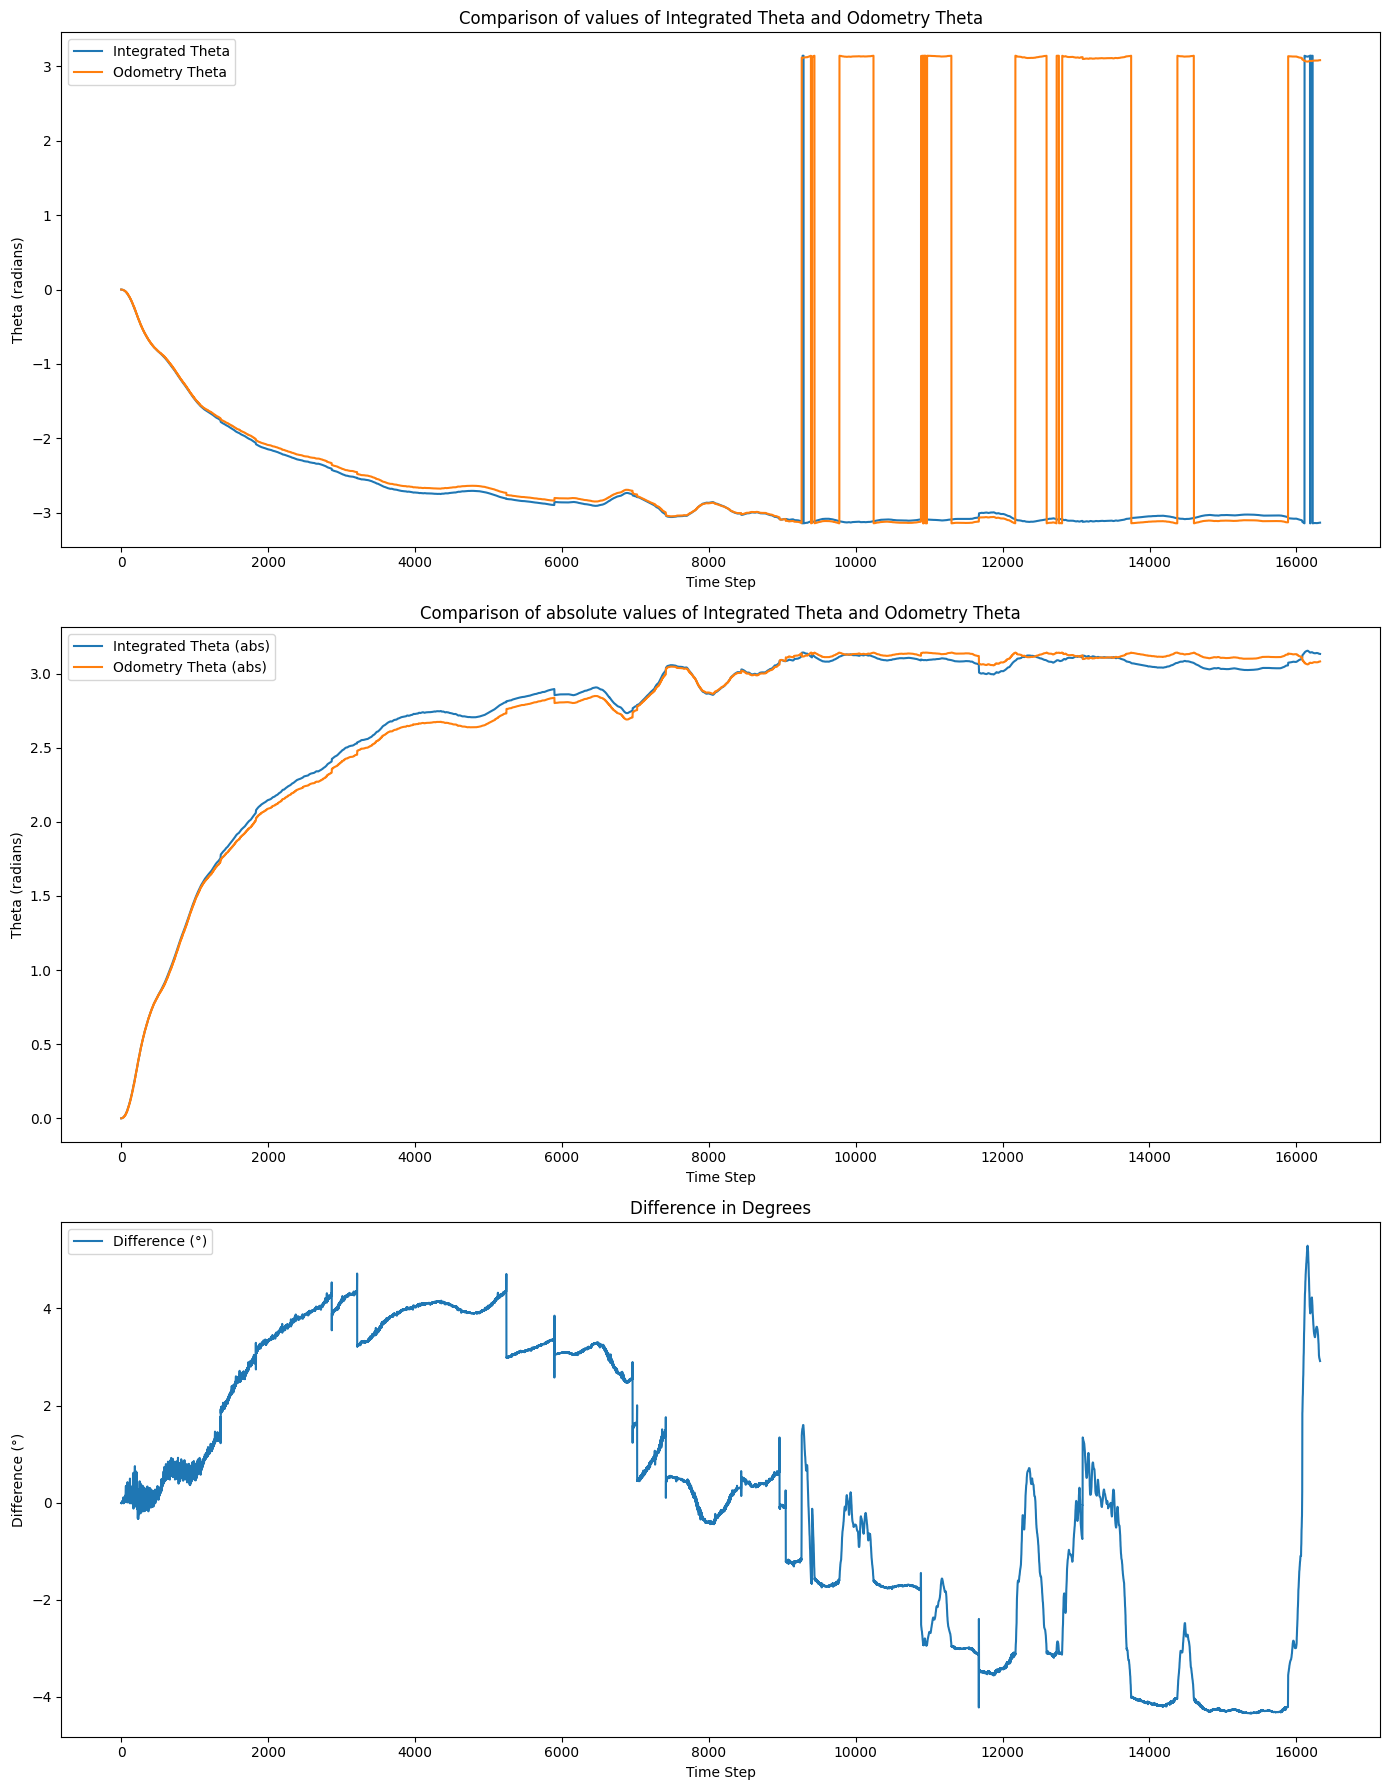

In [67]:
from scipy.optimize import minimize

def objective_function(dt, data, cutoff_frequency):
    filtered_local_w = low_pass_filter(data['local_w'], cutoff_frequency, 1/dt)
    integrated_theta_list, odometry_theta_list, _ = process_log_data_abs(pd.DataFrame({'local_w': filtered_local_w, 'odometry_theta': data['odometry_theta']}), dt)
    difference_sum = sum(abs(integrated_theta - odometry_theta) for integrated_theta, odometry_theta in zip(integrated_theta_list, odometry_theta_list))
    return difference_sum

# Initial guess for dt
initial_dt = 1 / sampling_rate

# Optimize dt
result = minimize(objective_function, initial_dt, args=(data, cutoff_frequency), bounds=bounds, method='L-BFGS-B')
optimal_dt = result.x[0]

print(f"The optimal dt is: {optimal_dt}, frequency: {1/optimal_dt}")

# Process and plot data with new dt
integrated_theta_list_new, odometry_theta_list_new, difference_list_new = process_log_data(data, optimal_dt)
integrated_theta_list_new_abs, odometry_theta_list_new_abs, difference_list_new_abs = process_log_data_abs(data, optimal_dt)

plt.figure(figsize=(14,18))

plt.subplot(3, 1, 1)
plt.plot(integrated_theta_list_new, label='Integrated Theta')
plt.plot(odometry_theta_list_new, label='Odometry Theta')
plt.xlabel('Time Step')
plt.ylabel('Theta (radians)')
plt.legend()
plt.title('Comparison of values of Integrated Theta and Odometry Theta')

plt.subplot(3, 1, 2)
plt.plot(integrated_theta_list_new_abs, label='Integrated Theta (abs)')
plt.plot(odometry_theta_list_new_abs, label='Odometry Theta (abs)')
plt.xlabel('Time Step')
plt.ylabel('Theta (radians)')
plt.legend()
plt.title('Comparison of absolute values of Integrated Theta and Odometry Theta')

plt.subplot(3, 1, 3)
plt.plot(difference_list_new_abs, label='Difference (°)')
plt.xlabel('Time Step')
plt.ylabel('Difference (°)')
plt.legend()
plt.title('Difference in Degrees')

plt.tight_layout()
plt.savefig("D:\\Chances\\Documents\\PS RoboCIn 2024.2\\result_plt.png")
plt.show()


In [68]:
# Create a dictionary with the values
result_dict = {
    'Odometry_Theta (abs)': odometry_theta_list_new_abs,
    'Integrated_Theta (abs)': integrated_theta_list_new_abs,
    'Difference (°)': difference_list_new_abs,
    'Sampling_Rate': sampling_rate,
}

# Convert the dictionary to a DataFrame
result_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in result_dict.items()]))

# Save the DataFrame to a CSV file
result_df.to_csv('result.csv', index=False)